# <span style="color:green"> Numerical Simulation Laboratory (NSL) Exercise 7 Results </span>

## 07.1

Use the Monte Carlo NVT code we have provided to <span style="color:red">print out instantaneous values of potential energy per particle, $U/N$, and pressure, $P$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)
1. <span style="color:red">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ and $P$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

#### DISCLAIMER
We know that our code and phyton scritp are not exactly polish, this is due to a series of corrections in different moments.

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import os
import re
plt.rcParams['figure.figsize'] = (15,10)


path = os.path.join(os.getcwd(), "MonteCarlo_NVT")
path_old = os.path.join(os.getcwd(), "MolecularDynamics_NVE")

n_part = 108
delta = [0.10,0.2,4.5]
rho = [1.1, 0.8,0.05]
r_c = [2.2,2.5,5.0]
T = [0.8,1.1,1.2]

def create_input_file(T, Np, Rho, Rcut, Delta, Blocks, Steps, E_Steps):
    with open(f"{path}/input.dat", 'w') as new_config:
        with open(f'{path}/input_origin.dat', 'r') as template_config:
            config = template_config.read()
            config = re.sub("{T}", str(T), config)
            config = re.sub("{Np}", str(Np), config)
            config = re.sub("{Rho}", str(Rho), config)
            config = re.sub("{Rcut}", str(Rcut), config)
            config = re.sub("{Delta}", str(Delta), config)
            config = re.sub("{Bloks}", str(Blocks), config)
            config = re.sub("{Steps}", str(Steps), config)
            config = re.sub("{Equilibration_Steps}", str(E_Steps), config)
            new_config.write(config)
def create_input_file_old(T, Np, Rho, Rcut, Delta, Blocks, StepsA, StepsB):
    with open(f"{path_old}/input.dat", 'w') as new_config:
        with open(f'{path_old}/input_origin.dat', 'r') as template_config:
            config = template_config.read()
            config = re.sub("{T}", str(T), config)
            config = re.sub("{Np}", str(Np), config)
            config = re.sub("{Rho}", str(Rho), config)
            config = re.sub("{Rcut}", str(Rcut), config)
            config = re.sub("{Delta}", str(Delta), config)
            config = re.sub("{StepsA}", str(StepsA), config)
            config = re.sub("{Bloks}", str(Blocks), config)
            config = re.sub("{StepsB}", str(StepsB), config)
            new_config.write(config)
def autocorr(x, t):
    t_max = x.size
    return ( np.dot(x[:t_max-t], x[t:t_max]) / (t_max - t) 
            - np.sum(x[:t_max-t]) * np.sum(x[t:t_max]) / (t_max - t)**2 ) /  np.var(x)

In [23]:
def equilibration(FORCE_NEW_RUN, Esteps):
    blocks = 0
    steps = 0
    equilibration = Esteps
    status = ['solid','liquid','gas']
    t =np.arange(equilibration)
    U = np.zeros((3,equilibration))
    U_seed = np.zeros((3,equilibration))
    U_shift = np.zeros((3,equilibration))
    fig, axs = plt.subplots(3, sharex=True);
    axs[0].set_title(f'Potential energy per particle {status[0]}')
    axs[0].set_ylabel(r'$\frac{U}{N}$')
   
    axs[1].set_title(f'Potential energy per particle {status[1]}')
    axs[1].set_ylabel(r'$\frac{U}{N}$')
    
    axs[2].set_title(f'Potential energy per particle {status[2]}')
    axs[2].set_ylabel(r'$\frac{U}{N}$')
    
    if FORCE_NEW_RUN:
        for i in range(3):
            subprocess.run(["bash", "./clean.sh"], cwd=path)
            create_input_file(T[i], n_part, rho[i], r_c[i], delta[i], blocks, steps, Esteps)
            subprocess.run(["./Monte_Carlo_NVT"], cwd=path)
            U[i] = np.loadtxt(f'{path}/0.epot')
            U_seed[i] = np.loadtxt(f'{path}/0.seed.epot')
            U_shift[i] = np.loadtxt(f'{path}/0.shift.epot')
            np.savetxt(f'{path}/equilibration_{status[i]}.dat',np.c_[U[i],U_seed[i], U_shift[i]],delimiter=' ')
    else:
        for i in range(3):
            U[i], U_seed[i], U_shift[i] = np.loadtxt(f'{path}/equilibration_{status[i]}.dat', unpack = True)
    axs[0].plot(t, U[0], '.', color= 'r')
    axs[0].plot(t, U_seed[0], '.', color= 'b')
    axs[0].plot(t, U_shift[0], '.', color= 'g')
    axs[0].set_ylim((-7.2, -4.0))

    axs[1].plot(t, U[1], '.', color= 'r')
    axs[1].plot(t, U_seed[1], '.', color= 'b')
    axs[1].plot(t, U_shift[1], '.', color= 'g')
    axs[1].set_ylim((-6.0, -4.0))

    axs[2].plot(t, U[2], '.' ,color= 'r')
    axs[2].plot(t, U_seed[2], '.', color= 'b')
    axs[2].plot(t, U_shift[2], '.', color= 'g')

def autocorrelation(FORCE_NEW_RUN):
    blocks = 10
    steps = 10**3
    equilibration = 10**3
    status = ['solid','liquid','gas']
    fig, axs = plt.subplots(3, sharex=True);
    t =np.arange(steps)
    A = np.zeros((3,steps))
    B = np.zeros((3,steps))
    
    axs[0].set_title(f'Autocorrelation Pressure and Potential energy per particle {status[0]}')
    axs[0].set_ylabel(r'$\chi(x)$')
    axs[1].set_title(f'Autocorrelation Pressure and Potential energy per particle {status[1]}')
    axs[1].set_ylabel(r'$\chi(x)$')
    axs[2].set_title(f'Autocorrelation Pressure and Potential energy per particle {status[2]}')
    axs[2].set_ylabel(r'$\chi(x)$')
    
    
    if FORCE_NEW_RUN:
        for i in range(3):
            subprocess.run(["bash", "./clean.sh"], cwd=path)
            create_input_file(T[i], n_part, rho[i], r_c[i], delta[i], blocks, steps, equilibration)
            subprocess.run(["./Monte_Carlo_NVT"], cwd=path)
            U = np.loadtxt(f'{path}/output.epot')
            P = np.loadtxt(f'{path}/output.pres')
            A[i] = np.vectorize(autocorr, excluded=[0])(U, t)
            B[i] = np.vectorize(autocorr, excluded=[0])(P, t)
            np.savetxt(f'{path}/autocorrelation_{status[i]}.dat',np.c_[A[i],B[i]],delimiter=' ')
    else:
        for i in range(3):
            A[i], B[i] = np.loadtxt(f'{path}/autocorrelation_{status[i]}.dat', unpack = True)
    axs[0].plot(t, A[0], '.')
    axs[0].plot(t, B[0], '.')
    axs[0].axhspan(-0.1, 0.1, alpha=0.2)
    axs[0].axhline(0)
    axs[1].plot(t, A[1], '.')
    axs[1].plot(t, B[1], '.')
    axs[1].axhspan(-0.1, 0.1, alpha=0.2)
    axs[1].axhline(0)
    axs[2].plot(t, A[2], '.')
    axs[2].plot(t, B[2], '.')
    axs[2].axhspan(-0.1, 0.1, alpha=0.2)
    axs[2].axhline(0)


In [19]:
def block_variation(evaluation, blocks_n):
    fig, axs = plt.subplots(6, sharex=True);
    k=0
    draw = [0,3,6]
    blocks = blocks_n
    block_dim = [10,100,1000]
    FORCE_NEW_RUN = evaluation
    status = ['solid','liquid','gas']
    equilibration = 10**3
    fig.tight_layout(pad=3.0)
    b =np.arange(blocks)
    U_block = np.zeros((9,blocks))
    U_err_block = np.zeros((9,blocks))

    P_block = np.zeros((9,blocks))
    P_err_block = np.zeros((9,blocks))
    axs[0].set_title(f'Potential energy per particle {status[0]}')
    axs[0].set_ylabel(r'$\frac{U}{N}$')
    axs[1].set_title(f'Pressure {status[0]}')
    axs[1].set_ylabel(r'$P$')
    
    axs[2].set_title(f'Potential energy per particle {status[1]}')
    axs[2].set_ylabel(r'$\frac{U}{N}$')
    axs[3].set_title(f'Pressure {status[1]}')
    axs[3].set_ylabel(r'$P$')
    
    axs[4].set_title(f'Potential energy per particle {status[2]}')
    axs[4].set_ylabel(r'$\frac{U}{N}$')
    axs[5].set_title(f'Pressure {status[2]}')
    axs[5].set_ylabel(r'$P$')
    
    if FORCE_NEW_RUN:
        for j in range(3):
            for i in range(3): 
                subprocess.run(["bash", "./clean.sh"], cwd=path)
                create_input_file(T[i], n_part, rho[i], r_c[i], delta[i], blocks, block_dim[j], equilibration)
                subprocess.run(["./Monte_Carlo_NVT"], cwd=path)
                U_block[k], U_err_block[k], P_block[k], P_err_block[k] = np.loadtxt(f'{path}/epot_pres.0', unpack=True)
                np.savetxt(f'{path}/e_block_{status[i]}_{block_dim[j]}.dat',np.c_[U_block[k],U_err_block[k]],delimiter=' ')#f'{path}/output.epot')
                np.savetxt(f'{path}/p_block_{status[i]}_{block_dim[j]}.dat',np.c_[P_block[k],P_err_block[k]],delimiter=' ')
                k = k+1
    else:
        for j in range(3):
            for i in range(3):
                U_block[k], U_err_block[k] = np.loadtxt(f'{path}/e_block_{status[i]}_{block_dim[j]}.dat', unpack = True)
                P_block[k], P_err_block[k] = np.loadtxt(f'{path}/p_block_{status[i]}_{block_dim[j]}.dat', unpack = True)
                k = k+1
    for m in range(3):  
        axs[0].errorbar(b, U_block[draw[m]], yerr=U_err_block[draw[m]], marker='.', linestyle='', label=f'L = {block_dim[m]}')
        axs[1].errorbar(b, P_block[draw[m]], yerr=P_err_block[draw[m]], marker='.', linestyle='', label=f'L = {block_dim[m]}')
    
        axs[2].errorbar(b, U_block[draw[m]+1], yerr=U_err_block[draw[m]+1], marker='.', linestyle='', label=f'L = {block_dim[m]}')
        axs[3].errorbar(b, P_block[draw[m]+1], yerr=P_err_block[draw[m]+1], marker='.', linestyle='', label=f'L = {block_dim[m]}')
    
        axs[4].errorbar(b, U_block[draw[m]+2], yerr=U_err_block[draw[m]+2], marker='.', linestyle='', label=f'L = {block_dim[m]}')
        axs[5].errorbar(b, P_block[draw[m]+2], yerr=P_err_block[draw[m]+2], marker='.', linestyle='', label=f'L = {block_dim[m]}')
    for ax in axs[:]:
        ax.grid(True)
        ax.legend()
    #fig.suptitle('Classic Lennard-Jones fluid, internal energy, pressure')
    axs[5].set_xlabel('Blocks')
    plt.show()

We present the result for equilibration procedure in the three phase situations, we've run three different starting situation and plotted the potential energy per particle as a function of the steps to identify the equilibration procedure time.

We have start our three simulation one in the usual simulation frame, one with a different seed and another with a previous configuration set up (so it can also be from a different phase situation, it vary every time, we are aware that this perhaps is not the best possible choice, but we want to try something different).

As we can see in the gas and liquid phase $1\times10^2$ iteration suffice to equilibrate the simulation.

In the solid case our simulation required more time in one situation, this is due to that run used previous configuration set and even if we increase the time steps over $1\times10^4$ the sistem remain stuck in another potential energy value.

This does not happen in the liquid or solid scenario (so it confirm that this wasn't a good alternative starting choise).

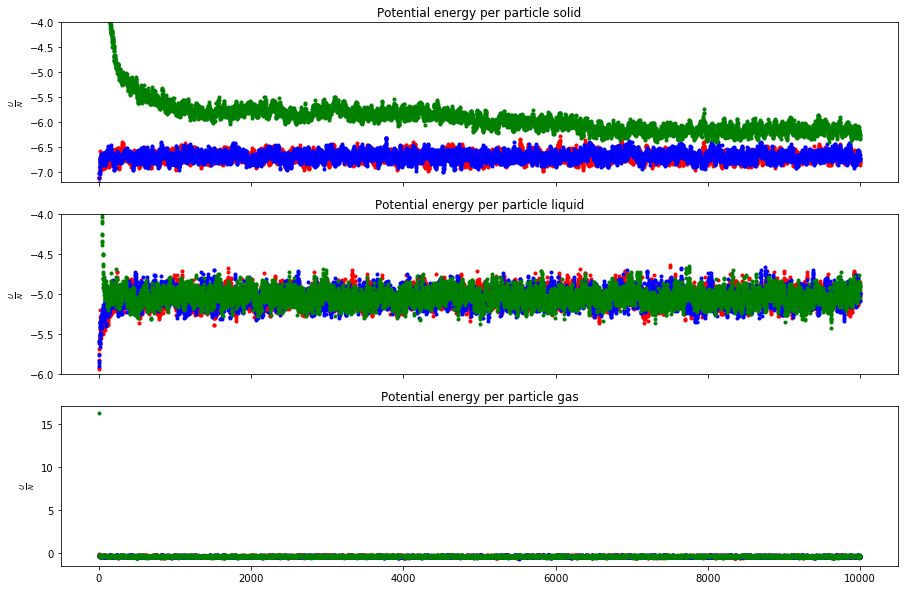

In [26]:
equilibration(True, 10000)

We've then evaluated in the three phase the autocorrelation function for the Potential Energy per particle.

The result allow us to estimate that a good block should contain at least $1\times10^2$ points in every situation.



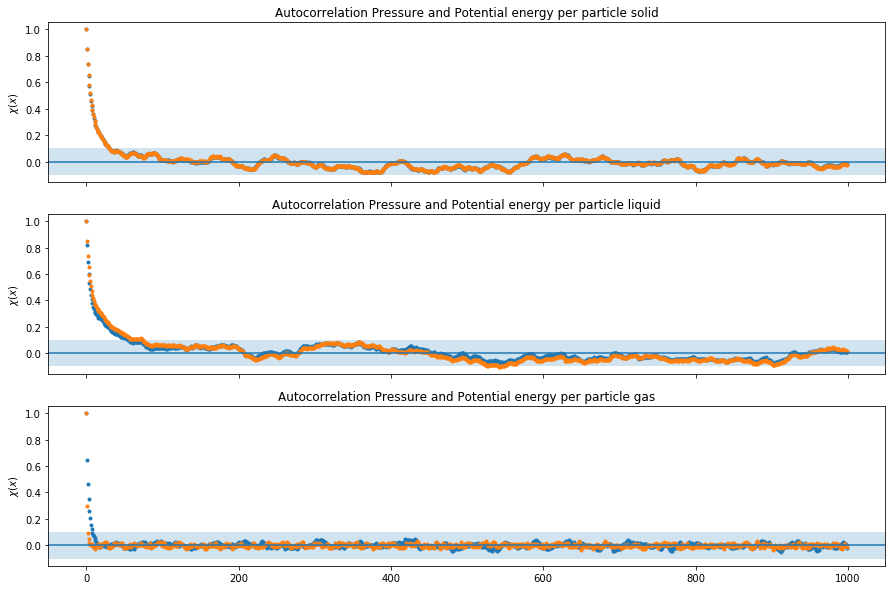

In [175]:
autocorrelation(True)

The autocorrelation results can be verified varing blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$.

We've decided to show only three results at  $L=M/N=10, 100, 1000$ for pressure and potential enerrgy.

Blocks's uncertainty after  $L=M/N= 1000$ does not improve, we've infact reach the true statistical erorr.

(Plot are TOO small, perhaps shows both Pressure and Potential Energy per particle results was not exactly the best idea, also print the uncertainty values would work better but still) 

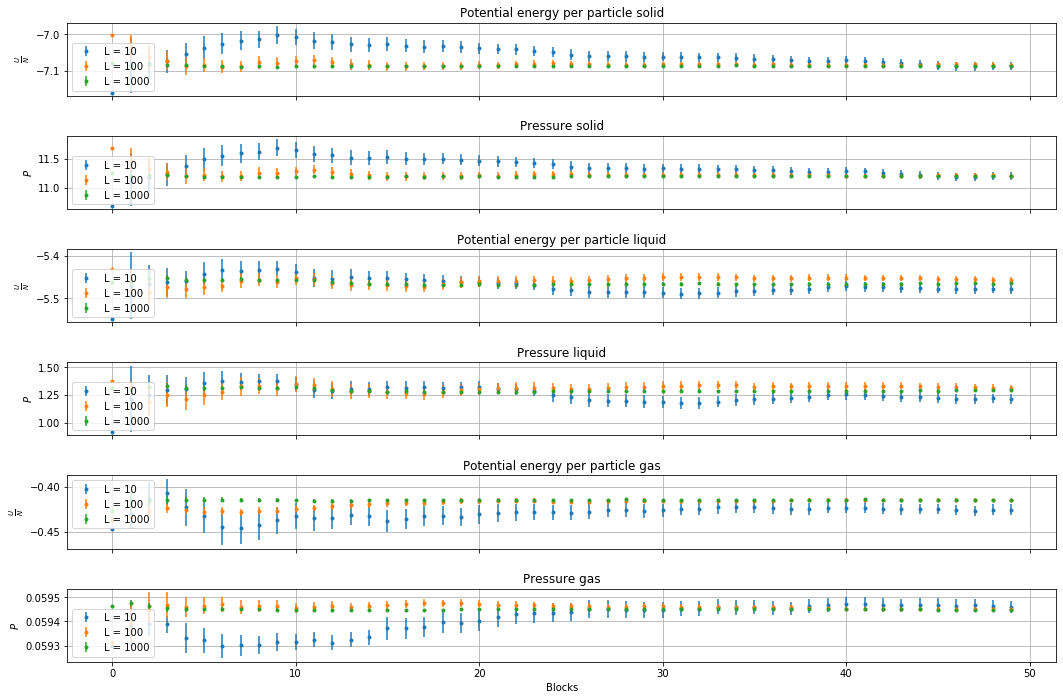

In [20]:
block_variation(False, 50)

## 07.2

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the Monte Carlo NVT code</span> we have provided: average value of $g(r)$ in each block (with output in the file: output.gofr.0), final average value of $g(r)$ with statistical uncertainties (with output in the file: output.gave.0).

In [46]:
def g_r_plot(method, FORCE_NEW_RUN, blocks_n, iteration):
    delta = [0.10,0.2,4.5]
    rho = [1.1, 0.8,0.05]
    r_c = [2.2,2.5,5.0]
    T = [0.8,1.1,1.2]

    blocks =  blocks_n
    steps = iteration
    equilibration = 10**3
    n =np.arange(100)
    fig, axs = plt.subplots(3, sharex=True)
    status = ['solid','liquid','gas']

    x = np.zeros((3,100))
    x_err = np.zeros((3,100))

    VA = np.zeros((3,100))
    binA = np.zeros((3,100))
    binA_dr = np.zeros((3,100))
    
    axs[0].set_title(f'Particles Radial distribution {status[0]}')
    axs[0].set_ylabel('g(r)')
    
    axs[1].set_title(f'Particles Radial distribution {status[1]}')
    axs[1].set_ylabel('g(r)')
    
    axs[2].set_title(f'Particles Radial distribution {status[2]}')
    axs[2].set_ylabel('g(r)')
    
    if method:
        if FORCE_NEW_RUN:
            for i in range(3): 
                subprocess.run(["bash", "./clean.sh"], cwd=path)
                create_input_file(T[i], n_part, rho[i], r_c[i], delta[i], blocks, steps, equilibration)
                subprocess.run(["./Monte_Carlo_NVT"], cwd=path)
                x[i],x_err[i],binA[i],binA_dr[i] = np.loadtxt(f'{path}/output.gave.0', unpack=True, usecols=(2,3,4,5))
                np.savetxt(f'{path}/gdir_block_{status[i]}.dat',np.c_[x[i],x_err[i],binA[i],binA_dr[i]],delimiter=' ')
                VA[i] = 3./(4.*np.pi*n_part*rho[i]*(binA_dr[i]**3 - binA[i]**3))
        else:
            for i in range(3):
                x[i],x_err[i],binA[i],binA_dr[i] = np.loadtxt(f'{path}/gdir_block_{status[i]}.dat', unpack=True)
                VA[i] = 3./(4.*np.pi*n_part*rho[i]*(binA_dr[i]**3 - binA[i]**3))
        
        axs[0].errorbar(n, VA[0]*x[0], yerr=VA[0]*x_err[0], marker='.', linestyle='-', color='r', zorder=10)
        axs[1].errorbar(n, VA[1]*x[1], yerr=VA[1]*x_err[1], marker='.', linestyle='-', color='r', zorder=10)
        axs[2].errorbar(n, VA[2]*x[2], yerr=VA[2]*x_err[2], marker='.', linestyle='-', color='r', zorder=10)
        plt.show()
    else:
        blocks =  blocks_n
        steps_old = [iteration,iteration]
        delta_old = 0.0005
        if FORCE_NEW_RUN:
            for i in range(3): 
                subprocess.run(["bash", "./clean.sh"], cwd=path_old)
                create_input_file_old(T[i], n_part, rho[i], r_c[i], delta_old, blocks,steps_old[0],steps_old[1])
                subprocess.run(["./MolDyn_NVE"], cwd=path_old)
                x[i],x_err[i],binA[i],binA_dr[i] = np.loadtxt(f'{path_old}/output.gave.0', unpack=True, usecols=(2,3,4,5))
                VA[i] = 3./(4.*np.pi*n_part*rho[i]*(binA_dr[i]**3 - binA[i]**3))
                np.savetxt(f'{path_old}/gdir_block_{status[i]}.dat',np.c_[x[i],x_err[i],binA[i],binA_dr[i]],delimiter=' ')#f'{path}/output.epot')
        else:
            for i in range(3):
                x[i],x_err[i],binA[i],binA_dr[i] = np.loadtxt(f'{path_old}/gdir_block_{status[i]}.dat', unpack=True)
                VA[i] = 3./(4.*np.pi*n_part*rho[i]*(binA_dr[i]**3 - binA[i]**3))
        
        axs[0].errorbar(n, VA[0]*x[0], yerr=VA[0]*x_err[0], marker='.', linestyle='-', color='r', zorder=10)
        axs[1].errorbar(n, VA[1]*x[1], yerr=VA[1]*x_err[1], marker='.', linestyle='-', color='r', zorder=10)
        axs[2].errorbar(n, VA[2]*x[2], yerr=VA[2]*x_err[2], marker='.', linestyle='-', color='r', zorder=10)
        plt.show()

We show the results in the three phase states for the radial distribution function with block evaluation, 50 blocks, every blocks with $1\times 10^4$ steps.

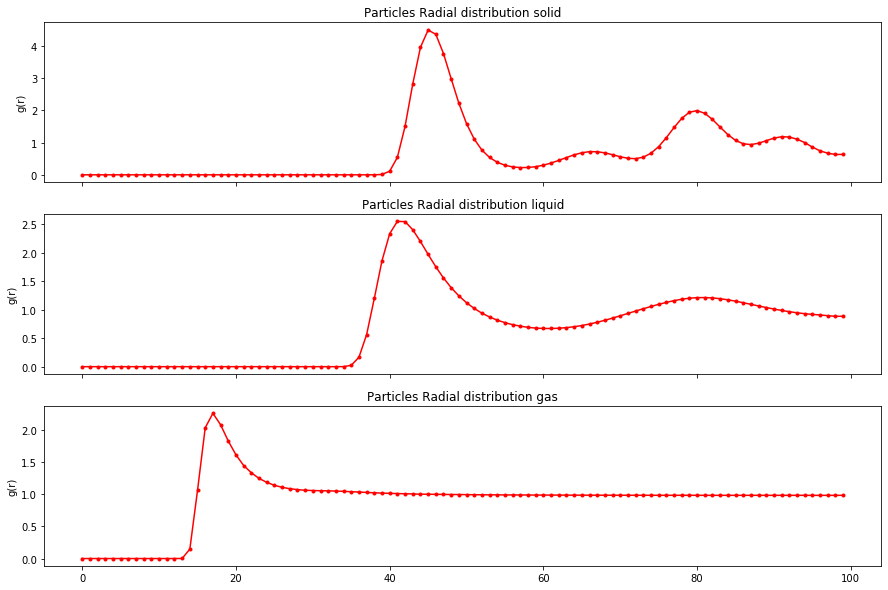

In [184]:
g_r_plot(True, False, 50, 10000)

## 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, inside the previously used Molecular Dynamics code</span>.

As above we show the results in the three phase states for the radial distribution function with block evaluation, this time with $1\times 10^5$ steps divided into 100 blocks.

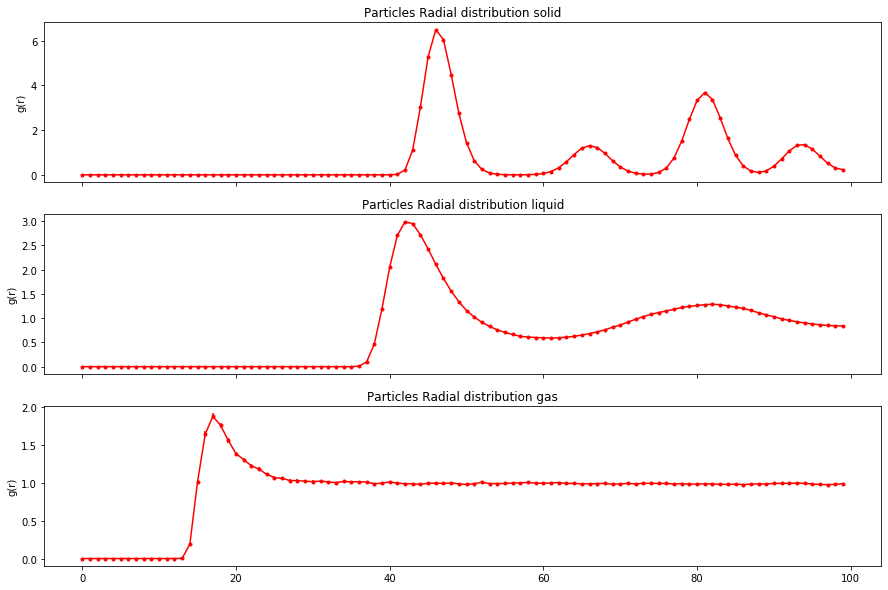

In [30]:
g_r_plot(False, True,100, 100000)

As can bee seen the shape in the two code are the same, the only difference is the height of the g(r) function for the liquid and gas phases, the origin of this mismatch is unclear, infact it is not the case in the gas function.

We suppose the origin of the variation is due to the different used algorithms.

We've also discovered that the prediction increases with the numbers of steps, however a simulation with more then $1\times 10^5$ steps wasn't completable for computational time problem.

## 07.4

By means of your upgraded MC code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in SI units ... <span style="color:red"> and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

The results are presented below, however for computational time problem and our (crazy) initial idea to run both simulation for the same run-time and same block average have proven difficult to show, so our result are presented with 100 blocks with 1000 iteration in each block.

In [82]:
def NTV(blocks_n, iteration, equilibration_s):
    delta = [0.10,0.2,4.5]
    rho = [1.1, 0.8,0.05]
    r_c = [2.2,2.5,5.0]
    T = [0.8,1.1,1.2]
    blocks =  blocks_n
    steps = iteration
    equilibration = equilibration_s
    status = ['solid','liquid','gas']   
    for i in range(3): 
            subprocess.run(["bash", "./clean.sh"], cwd=path)
            create_input_file(T[i], n_part, rho[i], r_c[i], delta[i], blocks, steps, equilibration)
            subprocess.run(["./Monte_Carlo_NVT"], cwd=path)
            x,x_err,binA,binA_dr = np.loadtxt('MonteCarlo_NVT/output.gave.0', unpack=True, usecols=(2,3,4,5))
            np.savetxt(f'MonteCarlo_NVT/gdir_block_{status[i]}.dat',np.c_[x,x_err,binA,binA_dr],delimiter=' ')
            U_block, U_err_block, P_block, P_err_block= np.loadtxt(f'{path}/epot_pres.0', unpack=True)
            np.savetxt(f'MonteCarlo_NVT/e_block_best_{status[i]}.dat',np.c_[U_block,U_err_block,P_block,P_err_block],delimiter=' ')
                #In this way we have to run only this part to have all the best results!!
#x,x_err,binA,binA_dr = np.loadtxt('MonteCarlo_NVT/output.gave.0', unpack=True, usecols=(2,3,4,5))
#np.savetxt(f'MonteCarlo_NVT/gdir_block_gas.dat',np.c_[x,x_err,binA,binA_dr],delimiter=' ')
#U_block, U_err_block, P_block, P_err_block= np.loadtxt(f'{path}/epot_pres.0', unpack=True)
#np.savetxt(f'MonteCarlo_NVT/e_block_best_gas.dat',np.c_[U_block,U_err_block,P_block,P_err_block],delimiter=' ')

In [80]:
def MolecularDynamics(molecule_name, sigma, Tinv, m, FORCE_NEW_RUN, FORCE_NEW_RUN_OLD):
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    import subprocess
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    rho = [1.1, 0.8,0.05]
    kb = 1.38064852e-23 # Boltzmann constant
    eps = Tinv * kb
    cwd = os.path.join(os.getcwd(), 'MolecularDynamics_NVE')
    parameters_new = {
        "number of steps": 1000,
        "number of blocks": 100,
        "equilibration steps":500,
    }
    parameters = {
        "n particles": 108,
        "time delta": 0.0005,
        "number of steps": 1000,
        "number of blocks": 100,
        "iprint": 1000,
        "read initial velocities": False,
        "rescale velocities": False
    }

    solid = {
        'label': 'Solid phase',
        'status': 'solid',
        'temperature': 0.8,
        'rho': 1.1,
        'cut-off radius': 2.2,
    }
    liquid = {
        'label': 'Liquid phase',
        'status': 'liquid',
        'temperature': 1.1,
        'rho': 0.8,
        'cut-off radius': 2.5,
    }
    gas = {
        'label': 'Gas phase',
        'status': 'gas',
        'temperature': 1.2,
        'rho': 0.05,
        'cut-off radius': 5
    }
    
    x = parameters["number of steps"]/parameters["number of blocks"]*np.arange(parameters["number of blocks"])

    fig, axes = plt.subplots(3, subplot_kw=dict(xlabel='steps'), figsize=(15,18))
    plt.subplots_adjust(hspace = 0.3)
    fig.suptitle(molecule_name, fontsize=25, x=0.5, y=.92, horizontalalignment='center', verticalalignment='top')
    axes = axes.flatten()
    #axes[-1].set_visible(False) # we just use 5 plots
    
    axes[0].set_title('Potential energy per particle')
    axes[0].set_ylabel(r'$\frac{U}{N}$')
    
    
    axes[1].set_title('Pressure')
    axes[1].set_ylabel(r'$P$')
    
    axes[2].set_title('Particles radial distribution')
    axes[2].set_ylabel('g(r)')

    for phase in [solid, liquid, gas]:
        label = phase['label']
        phaseStatus = phase['status']
        if FORCE_NEW_RUN_OLD:
            create_input_file_old(phase["temperature"], parameters["n particles"], phase["rho"], 
                              phase["cut-off radius"], parameters["time delta"],
                              parameters["number of blocks"], parameters["number of steps"], parameters["iprint"])
            subprocess.run(['./MolDyn_NVE', 'input.dat'], cwd=cwd)
            g,g_err,binA,binA_dr = np.loadtxt(f'{cwd}/output.gave.0', unpack=True, usecols=(2,3,4,5))
            VA = 3./(4.*np.pi*108*phase['rho']*(binA_dr**3 - binA**3))
            epot_mean, epot_err, pressure_mean, pressure_err = np.loadtxt(f'{cwd}/output.dat', unpack=True, usecols = (0,1,8,9))
            np.savetxt(f'{cwd}/data_block_{phaseStatus}.dat',np.c_[epot_mean, epot_err, pressure_mean, pressure_err],delimiter=' ')
            np.savetxt(f'{cwd}/gdir_block_{phaseStatus}.dat',np.c_[g,g_err,binA,binA_dr],delimiter=' ')
        else:
            epot_mean, epot_err, pressure_mean, pressure_err = np.loadtxt(f'{cwd}/data_block_{phaseStatus}.dat', unpack=True) 
            g,g_err,binA,binA_dr = np.loadtxt(f'{cwd}/gdir_block_{phaseStatus}.dat', unpack=True)
            VA = 3./(4.*np.pi*108*phase['rho']*(binA_dr**3 - binA**3))
        axes[0].errorbar(x, epot_mean* eps, yerr=epot_err* eps, label=label+"_NVE")
        axes[1].errorbar(x, pressure_mean * eps / sigma**3, yerr=pressure_err * eps / sigma**3, label=label+"_NVE")
        axes[2].errorbar(x, VA*g, yerr=VA*g_err, label=label+"_NVE")
    for ax in axes[:]:
        ax.grid(True)
        leg1 = ax.legend(title = 'States');
    var = np.arange(50)
    #if FORCE_NEW_RUN:
           # NTV(parameters_new["number of blocks"], parameters_new["number of steps"], parameters_new["equilibration steps"])
    for phase in [solid, liquid, gas]:
        label_NVT = phase['label']
        phaseStatus = phase['status']
        U_block, U_err_block, P_block, P_err_block = np.loadtxt(f'{path}/e_block_best_{phaseStatus}.dat', unpack = True)
        g,g_err,binA,binA_dr = np.loadtxt(f'{path}/gdir_block_{phaseStatus}.dat', unpack=True)
        VA = 3./(4.*np.pi*108*phase['rho']*(binA_dr**3 - binA**3))
        axes[0].errorbar(x, U_block * eps , yerr=U_err_block * eps , label=label_NVT+"_NTV")
        axes[1].errorbar(x, P_block* eps / sigma**3, yerr=P_err_block* eps / sigma**3, label=label_NVT+"_NTV")
        axes[2].errorbar(x, VA*g, yerr=VA*g_err, label=label_NVT+"_NTV")
    for ax in axes[:]:
        ax.grid(True)
        leg1 = ax.legend(title = 'States');
    #for ax in axes[:]:
    #    ax.grid(True)
    #    leg2 = ax.legend(title = 'States',loc='best');
    #    ax.add_artist(leg1)


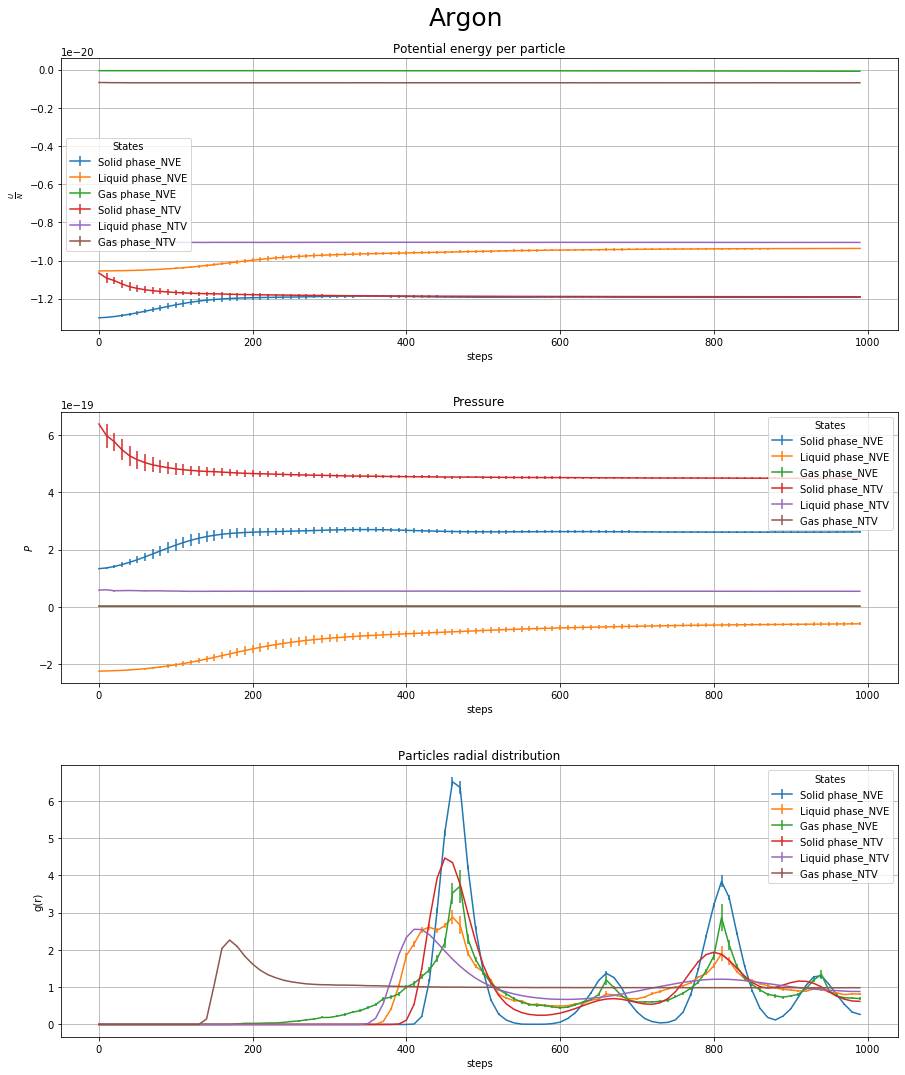

In [81]:
MolecularDynamics('Argon', 0.34, 120, 39.948, False,True)